In [1]:
import torch
import pandas as pd 
import numpy as np
import os 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from torch import optim

In [2]:
data_df1 = pd.read_csv('DownSampling/PPG_ds/ppg_signal_01_0001.csv')
data_df1.to_numpy().T

array([[ 5.34992686,  3.74868762,  2.24346025, ...,  3.60797491,
         4.12885474,  4.67721877],
       [-1.60123924, -1.55323331, -1.41290443, ...,  0.49439067,
         0.53462193,  0.54836403],
       [ 0.04800593,  0.0941674 ,  0.18101182, ...,  0.05185166,
         0.02698668,  0.0137421 ],
       [ 0.04616147,  0.06650295,  0.07977621, ..., -0.02283558,
        -0.01905478, -0.01324458]])

In [8]:
d_list = []
nan_index = []
counter = 0
#data_dir ='DownSampling/PPG_ds/'
data_dir ='data/'
for dir in os.listdir(data_dir):
    print(dir)
    if dir == '.ipynb_checkpoints':
        continue
    df = pd.read_csv(data_dir+dir)
    counter+=1
    if df.isnull().values.any():
        print(counter-1)
        nan_index.append(counter-1)
        print(dir)
        continue
    d_list.append(df.values.tolist()[0:9])

.ipynb_checkpoints
fiducials_signal_01_0001.csv
fiducials_signal_01_0002.csv
1
fiducials_signal_01_0002.csv
fiducials_signal_01_0003.csv
fiducials_signal_01_0004.csv
fiducials_signal_01_0005.csv
fiducials_signal_01_0006.csv
fiducials_signal_01_0007.csv
fiducials_signal_02_0001.csv
fiducials_signal_02_0002.csv
fiducials_signal_02_0003.csv
fiducials_signal_03_0001.csv
fiducials_signal_03_0002.csv
fiducials_signal_04_0001.csv
fiducials_signal_04_0002.csv
fiducials_signal_04_0003.csv
14
fiducials_signal_04_0003.csv
fiducials_signal_04_0004.csv
fiducials_signal_04_0005.csv
16
fiducials_signal_04_0005.csv
fiducials_signal_05_0001.csv
fiducials_signal_05_0002.csv
fiducials_signal_05_0003.csv
fiducials_signal_05_0004.csv
fiducials_signal_05_0005.csv
fiducials_signal_05_0006.csv
fiducials_signal_06_0001.csv
23
fiducials_signal_06_0001.csv
fiducials_signal_06_0002.csv
fiducials_signal_07_0001.csv
fiducials_signal_07_0002.csv
fiducials_signal_07_0003.csv
fiducials_signal_07_0004.csv
fiducials_sig

In [9]:
label_df = pd.read_csv('labels_final (2).csv')
label_df.head(20)

,ID,Gender,Age,Glucose,Height,Weight,Glucose_Level
0,1,'Male',38,99,180,53,2
1,1,'Male',38,102,180,53,3
2,1,'Male',38,103,180,53,3
3,1,'Male',38,128,180,53,6
4,1,'Male',38,130,180,53,6
5,1,'Male',38,134,180,53,7
6,1,'Male',38,136,180,53,7
7,2,'Male',25,111,187,75,5
8,2,'Male',25,108,187,75,4
9,2,'Male',25,118,187,75,5


In [10]:
label_df = label_df.drop(nan_index, axis=0)

In [13]:
len(d_list)

61

In [14]:
label_df.shape

(61, 7)

<Axes: >

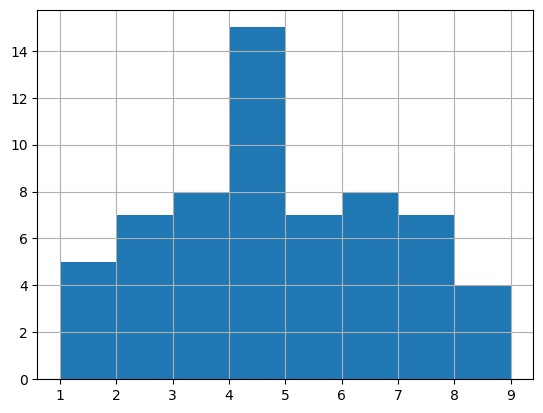

In [15]:
label_df['Glucose_Level'].hist(bins =8)

In [16]:
df_ = label_df[label_df['Glucose_Level'] == 6]

In [17]:
len(df_)

8

In [18]:
label_df.iloc[10:15]

,ID,Gender,Age,Glucose,Height,Weight,Glucose_Level
11,3,'Male',33,127,187,103,6
12,4,'Male',29,100,180,80,2
13,4,'Male',29,105,180,80,3
15,4,'Male',29,107,180,80,4
17,5,'Male',23,106,175,56,4


In [19]:
# one hot encoding
df_encoded = pd.get_dummies(label_df['Glucose_Level'])

In [20]:
from sklearn import preprocessing 
  
# label_encoder object knows  
label_encoder = preprocessing.LabelEncoder()  
label_df['Glucose_Level']= label_encoder.fit_transform(label_df['Glucose_Level']) 
  
label_df['Glucose_Level'].unique()

array([1, 2, 5, 6, 4, 3, 0, 7, 8], dtype=int64)

In [21]:
label_df['Glucose_Level']

0     1
2     2
3     5
4     5
5     6
     ..
62    5
63    3
64    0
65    1
66    3
Name: Glucose_Level, Length: 61, dtype: int64

In [22]:
Glucose = label_df['Glucose'].to_numpy()
#Glucose_level = label_df['Glucose_Level'].to_numpy()
Glucose_level = df_encoded.astype(int).values

In [23]:
X_train, sub_x, y_train, sub_y = train_test_split(d_list, Glucose_level, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(sub_x, sub_y, test_size = 1/3, random_state=42)

In [24]:
 y_test

array([[0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [25]:
#conver data to tensors
x_train_t = torch.tensor(X_train).float()
x_val_t = torch.tensor(X_val).float()
x_test_t = torch.tensor(X_test).float()
y_train_t = torch.tensor(y_train).float()
y_val_t = torch.tensor(y_val).float()
#dataset 
train_tensor = TensorDataset(x_train_t,y_train_t)
valid_tensor = TensorDataset(x_val_t,y_val_t)
# dataloader
dataloaders = dict()
dataloaders["train"] = DataLoader(train_tensor, batch_size=23, shuffle=True)
dataloaders["val"] = DataLoader(valid_tensor, batch_size=7)
dataloaders["test"] = DataLoader(x_test_t, batch_size=7)

In [26]:
y_train_t.shape

torch.Size([42, 9])

In [27]:
dataloaders['valid2'] =  DataLoader(x_val_t, batch_size=23)

In [28]:
dataloaders["test2"] = DataLoader(x_train_t, batch_size=1)

In [29]:
x_train_t.shape
len(dataloaders["test2"])

42

In [102]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len, dropout=0.5, output_size=9):
        super(RNN, self).__init__()
        
        # LSTM Layers
        self.lstm_1 = nn.LSTM(input_size, hidden_size[0], num_layers=2,
                              batch_first=True, bidirectional=True, dropout=dropout)
        self.lstm_2 = nn.LSTM(2 * hidden_size[0], hidden_size[1], num_layers=2,
                              batch_first=True, bidirectional=True, dropout=dropout)
        
        # Fully Connected Layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_sizes[1] * 2*9, 4096),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            #nn.Dropout(p=dropout),
            nn.Linear(1024, output_size),
            ##nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        # LSTM layers:
        x1, _ = self.lstm_1(x)
        x2, _ = self.lstm_2(x1)
        
        # Fully connected layers:
        x = x2.reshape(x2.shape[0], -1)
        x = self.fc(x)
        return x

In [103]:
#more comlex model

# Definition of a RNN Model class
class RNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, seq_len, dropout=0.01, output_size=9):
        super(RNN, self).__init__()
        
        # LSTM Layers
        self.lstm_1 = nn.LSTM(input_size, hidden_sizes[0], num_layers=2,
                            batch_first=True, bidirectional=True, dropout=dropout)
        self.lstm_21 = nn.LSTM(2*hidden_sizes[0], hidden_sizes[1], num_layers=2,
                             batch_first=True, bidirectional=True, dropout=dropout)
        self.lstm_22 = nn.LSTM(input_size, hidden_sizes[1], num_layers=2,
                             batch_first=True, bidirectional=True, dropout=dropout)
        self.lstm_31 = nn.LSTM(2*hidden_sizes[1], hidden_sizes[2], num_layers=2,
                             batch_first=True, bidirectional=True, dropout=dropout)
        self.lstm_32 = nn.LSTM(4*hidden_sizes[1], hidden_sizes[2], num_layers=2,
                             batch_first=True, bidirectional=True, dropout=dropout)
        self.lstm_41 = nn.LSTM(2*hidden_sizes[2], hidden_sizes[3], num_layers=2,
                             batch_first=True, bidirectional=True, dropout=dropout)
        self.lstm_42 = nn.LSTM(4*hidden_sizes[2], hidden_sizes[3], num_layers=2,
                             batch_first=True, bidirectional=True, dropout=dropout)
        hidd = 2*hidden_sizes[0] + 4*(hidden_sizes[1]+hidden_sizes[2]+hidden_sizes[3])
        self.lstm_5 = nn.LSTM(hidd, hidden_sizes[4], num_layers=2,
                             batch_first=True, bidirectional=True, dropout=dropout)
        
        # Fully Connected Layer
        self.fc = nn.Sequential(nn.Linear(8*2*460, 4096),
                                nn.ReLU(),
                                nn.Dropout(p=dropout),
                                nn.Linear(4096, 1024),
                                nn.ReLU(),
                                nn.Dropout(p=dropout),
                                nn.Linear(1024, output_size),
                                nn.Softmax(dim =1)
                               )
        
    def forward(self, x):
        
        # lstm layers:
        x1, _ = self.lstm_1(x)
        
        x_x1, _ = self.lstm_21(x1)
        x_x2, _ = self.lstm_22(x)
        x2 = torch.cat([x_x1, x_x2], dim=2)
        
        x_x1, _ = self.lstm_31(x_x1)
        x_x2, _ = self.lstm_32(x2)
        x3 = torch.cat([x_x1, x_x2], dim=2)
        
        x_x1, _ = self.lstm_41(x_x1)
        x_x2, _ = self.lstm_42(x3)
        x4 = torch.cat([x_x1, x_x2], dim=2)
        x = torch.cat([x1, x2, x3, x4], dim=2)
        x, _ = self.lstm_5(x)
        
        # fully connected layers:
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


'\n# Definition of a RNN Model class\nclass RNN(nn.Module):\n    def __init__(self, input_size, hidden_sizes, seq_len, dropout=0.01, output_size=9):\n        super(RNN, self).__init__()\n        \n        # LSTM Layers\n        self.lstm_1 = nn.LSTM(input_size, hidden_sizes[0], num_layers=2,\n                            batch_first=True, bidirectional=True, dropout=dropout)\n        self.lstm_21 = nn.LSTM(2*hidden_sizes[0], hidden_sizes[1], num_layers=2,\n                             batch_first=True, bidirectional=True, dropout=dropout)\n        self.lstm_22 = nn.LSTM(input_size, hidden_sizes[1], num_layers=2,\n                             batch_first=True, bidirectional=True, dropout=dropout)\n        self.lstm_31 = nn.LSTM(2*hidden_sizes[1], hidden_sizes[2], num_layers=2,\n                             batch_first=True, bidirectional=True, dropout=dropout)\n        self.lstm_32 = nn.LSTM(4*hidden_sizes[1], hidden_sizes[2], num_layers=2,\n                             batch_first=True,

In [104]:
### VALIDATION FUNCTION
def validation(model, loader, criterion, device="cpu"):
    model.eval()
    loss = 0
    preds_all = torch.LongTensor()
    labels_all = torch.LongTensor()
    
    with torch.no_grad():
        for batch_x, labels in loader:
            labels_all = torch.cat((labels_all, labels), dim=0)
            batch_x, labels = batch_x.to(device), labels.to(device)
            labels = labels.float()
            
            output = model.forward(batch_x)
            loss += criterion(output,torch.argmax(labels, dim=1)).item()
            #loss += criterion(output,labels.long()).item()
            preds_all = torch.cat((preds_all, output.to("cpu")), dim=0)
    total_loss = loss/len(loader)
    
    return total_loss

In [105]:
len(dataloaders['train'])

2

In [106]:
 for batch_x, labels in dataloaders['train']:
            labels = labels.float()

In [107]:
### TRAINING FUNCTION
def train_model(model, trainloader, validloader, criterion, optimizer, 
                scheduler, epochs=20, device="cpu", print_every=1):
    model.to(device)
    best_valid = 10
    best_epoch = 0
    for e in range(epochs):
        model.train()
        
        for batch_x, labels in trainloader:
            batch_x, labels = batch_x.to(device), labels.to(device)
            labels = labels.float()
            
            # Training 
            optimizer.zero_grad()
            output = model.forward(batch_x)
            loss = criterion(output, torch.argmax(labels, dim=1))
            #loss = criterion(output, labels.long())
            loss.backward()
            optimizer.step()
            scheduler.step()
        # at the end of each epoch calculate loss and auc score:
        model.eval()
        train_loss = validation(model, trainloader, criterion, device)
        valid_loss = validation(model, validloader, criterion, device)
        if valid_loss < best_valid:
            best_valid = valid_loss
            best_epoch = e
            torch.save(model.state_dict(), "best-state.pt")
        if e % print_every == 0:
            to_print = "Epoch: "+str(e+1)+" of "+str(epochs)
            to_print += ".. Train Loss: {:.4f}".format(train_loss)
            to_print += ".. Valid Loss: {:.4f}".format(valid_loss)
            to_print += ".. best Valid : {:.4f}".format(best_valid)

            print(to_print)
    # After Training:
    torch.save(model.state_dict(), "best-state.pt")
    model.load_state_dict(torch.load("best-state.pt"))
    to_print = "\nTraining completed. Best state dict is loaded.\n"
    print(to_print)
    return

In [108]:
input_size = len(d_list[1][1])
input_size

16

In [109]:
len(d_list[1][1])

16

In [110]:
sequence_length = len(x_train_t)
input_size = len(d_list[1][1])
#hidden_sizes = [192, 144, 96, 32,8]
hidden_sizes = [376*2*2, 192*2*2, 144, 96,32]
#hidden_sizes = [96,8]
max_learning_rate = 0.001
epochs = 50

# Model
model_lstm = RNN(input_size, hidden_sizes, sequence_length)
print("Model: ")
print(model_lstm)

# criterion, optimizer, scheduler
#criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss() # in cass of useing remove the softmax layer CrossEntropyLoss() apply softmax automacly
#criterion = nn.BCELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=max_learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr = max_learning_rate,
                                          epochs = epochs + 1,
                                          steps_per_epoch = int(len(dataloaders["train"])),
                                          pct_start = 0.2,
                                          anneal_strategy = "cos")

Model: 
RNN(
  (lstm_1): LSTM(16, 1504, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (lstm_2): LSTM(3008, 768, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=13824, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=1024, bias=True)
    (4): ReLU()
    (5): Linear(in_features=1024, out_features=9, bias=True)
  )
)


In [111]:
%%time
# Checking if GPU is available
if torch.cuda.is_available():
    my_device = "cpu"
    print("GPU is enabled")
else:
    my_device = "cpu"
    print("No GPU :(")

# Training
train_model(model = model_lstm,
            trainloader = dataloaders["train"],
            validloader = dataloaders["val"],
            criterion = criterion,
            optimizer = optimizer,
            scheduler = scheduler,
            epochs = epochs,
            device = my_device,
            print_every = 2)

GPU is enabled
Epoch: 1 of 50.. Train Loss: 2.1814.. Valid Loss: 2.1785.. best Valid : 2.1785
Epoch: 3 of 50.. Train Loss: 2.0723.. Valid Loss: 2.0883.. best Valid : 2.0883
Epoch: 5 of 50.. Train Loss: 2.1267.. Valid Loss: 2.1223.. best Valid : 2.0883
Epoch: 7 of 50.. Train Loss: 2.1106.. Valid Loss: 2.1097.. best Valid : 2.0354
Epoch: 9 of 50.. Train Loss: 2.0569.. Valid Loss: 2.0342.. best Valid : 2.0342
Epoch: 11 of 50.. Train Loss: 2.1954.. Valid Loss: 2.1628.. best Valid : 2.0342
Epoch: 13 of 50.. Train Loss: 2.1841.. Valid Loss: 2.1142.. best Valid : 2.0342
Epoch: 15 of 50.. Train Loss: 2.0977.. Valid Loss: 2.0836.. best Valid : 2.0342
Epoch: 17 of 50.. Train Loss: 2.0774.. Valid Loss: 2.0551.. best Valid : 2.0290
Epoch: 19 of 50.. Train Loss: 2.0904.. Valid Loss: 2.1129.. best Valid : 2.0290
Epoch: 21 of 50.. Train Loss: 2.0616.. Valid Loss: 2.0470.. best Valid : 2.0290
Epoch: 23 of 50.. Train Loss: 2.0634.. Valid Loss: 2.0172.. best Valid : 2.0172
Epoch: 25 of 50.. Train Loss: 

In [112]:
model_lstm.load_state_dict(torch.load("best-state.pt"))
def prediction(model, loader, device="cpu"):
    model.to(device)
    model.eval()
    preds_all = torch.LongTensor()
    
    with torch.no_grad():
        for batch_x in loader:
            batch_x = batch_x.to(device)
            output = model.forward(batch_x).to("cpu")
            preds_all = torch.cat((preds_all, output), dim=0)
    return preds_all

In [120]:
y_pred = prediction(model_lstm, dataloaders['valid2'], device='cpu')

In [121]:
n = 0
for i in range(len(y_pred)):
    if y_pred[i].argmax() == y_val_t[i].argmax():
        n += 1
print('acc: ',n/len(y_val_t)*100, '%')
print(n)        

acc:  25.0 %
3
